### Time Series Prediction and Spatial Data Clustering on Large Earthquakes

This project made use of a publicly accessible open dataset "Significant Earthquakes, 1965-2016" released by the US Geological Survey, available on Kaggle at: https://www.kaggle.com/usgs/earthquake-database.

It contains over 23,000 major earthquake events with a recorded magnitude of 5.5 or above over the past 50-year period. Predicting earthquakes is an active research topic involving time-series and sequence modelling, and meanwhile a challenging task owing to high uncertainties and complexities of the Earth dynamic systems. Without much emphases on prior geological or earth science knowledge, applying purely data-driven unsupervised feature learning and predictive methods can help recognize spatial and temporal patterns through training sequnece based and time series models.

Layout of this notebook includes:
  - Spatial Clustering by HDBSCAN
      - reasonble to assume or believe there exists a certain extent of homogeneity or pattern within a zone of frequent occurrences
      - previewing the spatial distribution could give a preliminary visualization and group dense target regions
      - haver-sine distance for representing Earth surface curvature
  - Sequence Modelling
      - Hidden Markov Model (HMM), Conditional Random Field (CRF), Bayesian Net
      - investigate the order of occurrences of large earthquakes across regional partitions
  - Time-series based feature extractions
      - creating data of time lags
  - Long-Short Term Memmory (LSTM) network
      - predicting magnitudes of large earthquakes in future periods
      - predicting counts of large earthquakes in future periods

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

## read the raw data
df = pd.read_csv(F'drive/My Drive/Colab Notebooks/earthquake.csv')

## Cleaning on date attribute: convert string to date format and extract year, month, day
time_arr = [pd.Period(item) for item in np.array(df['Date'])]
df['Date'] = time_arr
df['year'] = df['Date'].apply(lambda x: x.year)
df['month'] = df['Date'].apply(lambda x: x.month)
df['day'] = df['Date'].apply(lambda x: x.day)

In [0]:
df[0:10]

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,year,month,day
0,1965-01-02,13:44:18,19.246,145.616,Earthquake,131.6,6.0,1965,1,2
1,1965-01-04,11:29:49,1.863,127.352,Earthquake,80.0,5.8,1965,1,4
2,1965-01-05,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,1965,1,5
3,1965-01-08,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,1965,1,8
4,1965-01-09,13:32:50,11.938,126.427,Earthquake,15.0,5.8,1965,1,9
5,1965-01-10,13:36:32,-13.405,166.629,Earthquake,35.0,6.7,1965,1,10
6,1965-01-12,13:32:25,27.357,87.867,Earthquake,20.0,5.9,1965,1,12
7,1965-01-15,23:17:42,-13.309,166.212,Earthquake,35.0,6.0,1965,1,15
8,1965-01-16,11:32:37,-56.452,-27.043,Earthquake,95.0,6.0,1965,1,16
9,1965-01-17,10:43:17,-24.563,178.487,Earthquake,565.0,5.8,1965,1,17


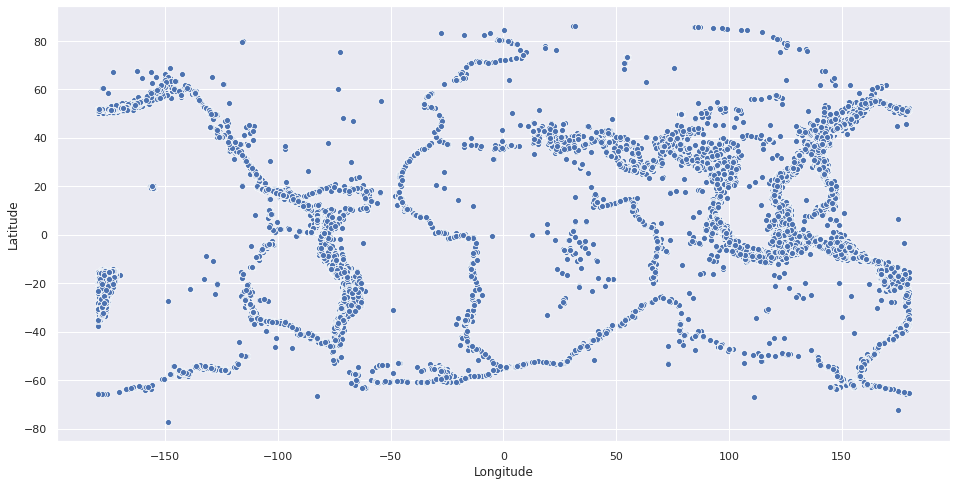

In [2]:
# Part 1):
# To partition or group geo-location (coordinates) by unsupervised methods;
# Do exploratory analyses
coord = np.matrix(df.iloc[:,2:4])
seaborn.set(rc={'figure.figsize':(16.0, 8.0)})
seaborn.scatterplot(x=df.iloc[:,3], y=df.iloc[:,2])

#### Spatial Clustering by HDBSCAN:

For the prediction tasks, since the 5.5 or above earthquake events were an irregularly spaced time series, the following were two interesting ideas for initializing some trials:
1. Partition all data points into clusters;
   Obtain an earthquake sequence in temporal order by the segmented regions; 
   Predict the region for the next earthquake.
2. Cluster the locations of frequent events;
   Aggregate the features for the cluster-specific time series into equally-spaced intervals;
   Predict on the values of the aggregated features for the next t + 1, t + 2, … t + n intervals

Clustering would be the first step for both analyses. 

Partition-based methods like K-means, K-medoids or hierarchical clustering which produced cluster memberships for each observation would be appropriate choices for the first approach. Density-based methods like DBSCAN and OPTICS would be powerful for the second to eliminate sparse outliers, and sorted out frequent occurrence zones employing the k nearest neighbour concept. Spatial data distributed on the Earth surface could not simply be applied with the Euclidean distance for the clustering algorithm, instead, haversine distance formula on the separations between two points on a spherical surface would give a better geometrical representation that would not distort the data in a large extent. 

Haversine is supported as a distance metric for the DBSCAN function in the well-known scikit-learn library, but not for K-means or hierarchical clustering. To resolve this, one idea was calculating the distance matrix as input, yet it was not easy for large number of observations in terms of computational memory and time. An alternative might be manually converting the latitude and longitude angular values with Earth’s radius to cartesian coordinates and calculate distance based on that. Particularly, the modified spherical K-means would project the centroids on an unit sphere with standardization on the input data.

<img src="https://user-images.githubusercontent.com/2789198/27240432-e67a0cf0-52d4-11e7-9acb-b935e1a84f47.png" width="450" height="200" />

In [0]:
## convert locations to cartesian coordinates
# Earth radius
r = 6371
def cart_coor(lat, long):
    ## convert to radian expressions
    theta1 = np.radians(lat)
    theta2 = np.radians(long)
    ## Cartesian coordinate
    x = r * np.cos(theta2) * np.cos(theta1)
    y = r * np.sin(theta2) * np.cos(theta1)
    z = r * np.sin(theta1)
    return np.concatenate([x, y, z], axis=1)

coord_X = [cart_coor(i, j) for i, j in zip(coord[:,0], coord[:,1])]
flat = np.concatenate(coord_X, axis=0)

In DBSCAN, the parameter of minimum data points required to form a cluster could be adjusted by "min_cluster_size". 

There was a trade-off between the representativeness or interpretability of the formed clusters and the number of outliers remaining unlabelled. If the “min_cluster_size” was set smaller, more clusters could be identified, yet the clustering process might need to be recursively grouping neighbouring clusters to resemble a locally dense earthquake zone. If the “min_cluster_size” was set high, some clusters might be eliminated and thus declared as outliers, this would induce the risk of excluding indeed crucial data.

Here, HDBSCAN library includes the algorithm of a hierarchical version of DBSCAN, which would be of high performance and fast clustering. HDBSAN supports coordinates expressed in radians when implementing the Haversine metric for clustering, so we can convert the latitude and longitude data into radians and pass the inputs to the HDBSCAN function.

At first, I tried with a min_cluster_size=180 cluster solution, returning 32 clusters. It seems that some dense earthquake regions, like South-east Asian subduction zone and North Pacific Aleutian-to-Japan Trench were separated into several clusters, with notable amount of outliers near them. That means, within a frequent earthquake area, not all the points were being well captured. 

Re-running with increasing min_cluster_size in range from 180 to 1080 gradually (transition as seen in the following plots), through manual evaluation or some gap statistics, we could choose the more likely cluster solutions with sufficient data points captured for each major earthquake region for the later region-specific time series modelling.

In [0]:
!pip install hdbscan
!pip install pyclustering
!pip install spherecluster
!pip install hmmlearn
!pip install sklearn-crfsuite
!pip install pomegranate
!pip install pgmpy

In [0]:
import hdbscan
# fit a HDBSCAN with larger cluster size & haversine distance
def hdbsacn_spatial_clustering(min_cluster_size):
  hdbc = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=1, alpha=0.01, 
                        prediction_data=True, metric='haversine')
  predictions = hdbc.fit_predict(np.radians(coord))
  return predictions

<img src="pic/Figure_180 size.png" />
<img src="pic/Figure_240 size.png" />
<img src="pic/Figure_360 size.png" />

In [0]:
# append cluster membership column to the dataframe
df['Loc_Dense_Areas'] = hdbsacn_spatial_clustering(1080)

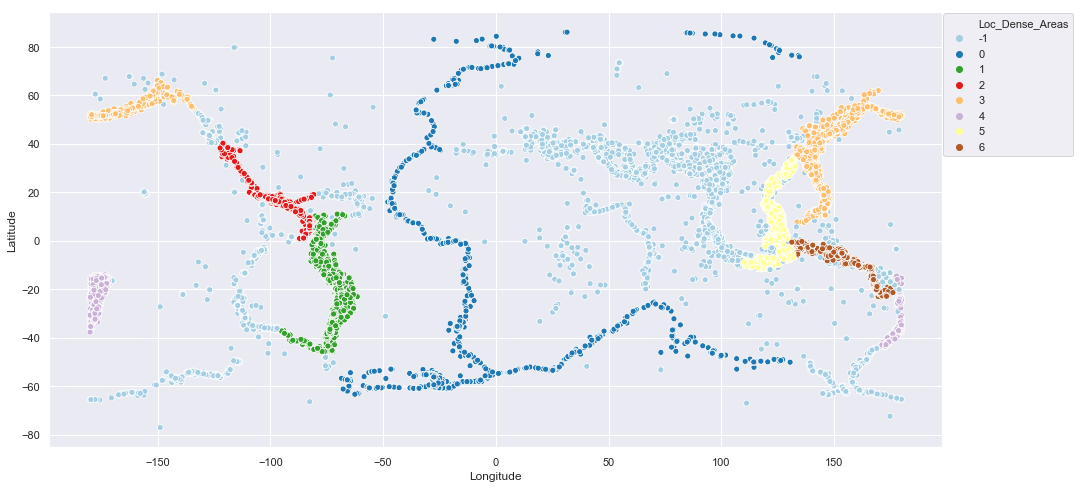

In [0]:
# plot of dense earthquake occurrence regions
seaborn.scatterplot(x=df.iloc[:,3], y=df.iloc[:,2], palette='Paired',
                    hue='Loc_Dense_Areas', legend='full', data=df)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)

Finally, the 1080 cluster-size solution distinguished most of the neighboring data points for the 7 dense regions. These labels are: <br>
0: Mide-Atlantic Ridge and Antartic Plate; <br>
1: Peru–Chile Trench and the East of Nazca Plate; <br>
2: California San Andreas Fault and Middle America Trench; <br>
3: Aleutian Trench, Japan Trench extended to Mariana Trench; <br>
4: Tonga Trench and New Zealand; <br>
5: Phillipine Trench, Java Trench; <br>
6: Indonesian and Bougainville Trench. 

Generally, the so-called "Ring of Fire" could be depicted by these clusters.

To group the outlier points into a segement, we needed to be proceeding to partion clustering, from the 32 clusters obtained with min_cluster_size=180, I specified k = 30. Comparing K-medoids and the spherical K-means on the intuitively 30-cluster solutions, the results were generally similar. Spherical K-means successfully distinguished the bending area along the Aleutian Trench in 1 cluster, while K-medoids sliced it into 5 clusters. K-medoids messed up by splitting Indian Plate earthquake belt into 3 clusters, in which 1 among them (red-colored in the plot) was confused with data points obviously from other dense regions. Results from spherical K-means was then preferred.

Diagnostics was not provided here, yet it would be encouraged to investigate average silhouette within clusters, gap statistic, or even by making more trials to choose the optimal number of clusters.

In [0]:
## fit a k-medoids clustering with pre-defined cluster size
from pyclustering.cluster.kmedoids import kmedoids
## 30 clusters
ini_med = np.array(range(1, 31))
kmed = kmedoids(flat, ini_med)
kmed.process()
projections1 = kmed.get_clusters()

## manually extract cluster labels for k-medoids
a = []
b = []
for x in range(0, len(projections1)):
    for y in range(0, len(projections1[x])):
        a.append(x)
        b.append(projections1[x][y])

kmed_member = pd.DataFrame(a, b)
predictions1 = kmed_member.sort_index(axis=0)

No handles with labels found to put in legend.


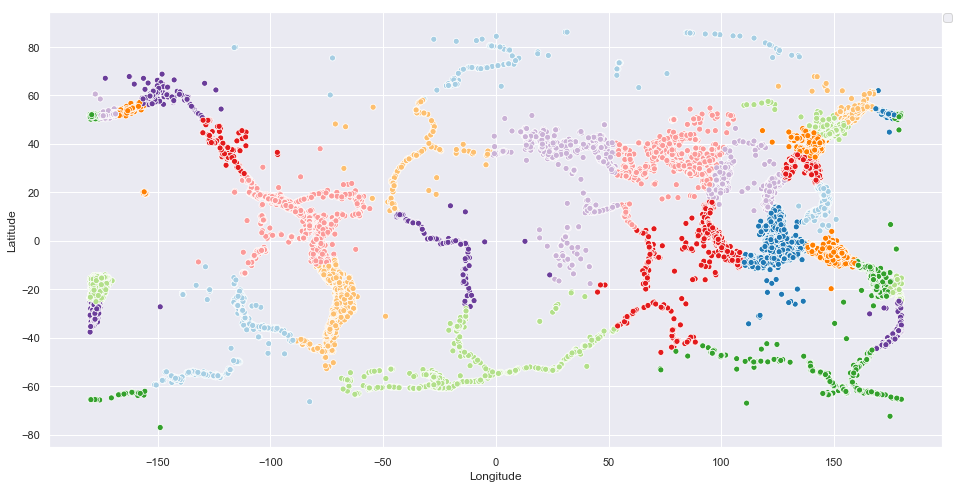

In [0]:
color_palette = seaborn.color_palette('deep', len(projections1))
kmed_cluster_colors = [color_palette[x] for x in predictions1[0]]

seaborn.scatterplot(x=df.iloc[:,3], y=df.iloc[:,2], palette='Paired',
                    hue=kmed_cluster_colors, legend=False)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)

In [6]:
## Use k-means from spherical clustering
from spherecluster import SphericalKMeans
spkmeans = SphericalKMeans(n_clusters=30, random_state=42)
spkmeans_labels = spkmeans.fit_predict(flat)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [0]:
# append cluster membership column to the dataframe
df['Loc_partition'] = spkmeans_labels

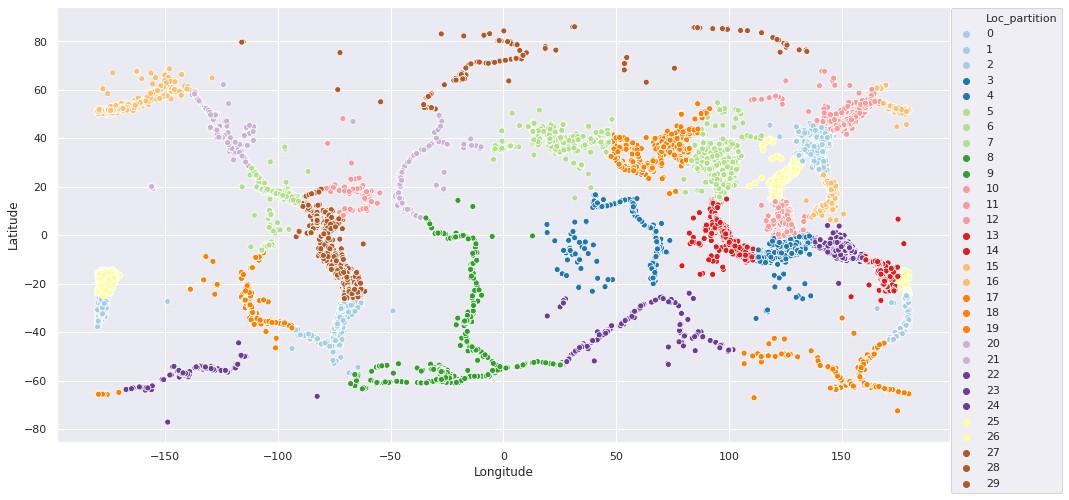

In [0]:
color_palette = seaborn.color_palette('deep', len(set(spkmeans_labels)))
spkm_cluster_colors = [color_palette[x] for x in spkmeans_labels]

seaborn.scatterplot(x=df.iloc[:,3], y=df.iloc[:,2], palette='Paired',
                    hue='Loc_partition', legend='full', data=df)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)

#### Exploratory spline fitting and smoothing:

The dataset doe not contain many features, besides time and spatial features, depth and magnitude are two critical information provided. Further exploring the relationship between depth and magnitude, smoothers like Lowess (non-parametric locally weighted regression for scatterplots) and robust regression are nice tools for investigating any observed pattern. The smoothing curves turned out to be rather flattened, merely concluding that magnitudes and depths of earthquakes did not have any relationship. 

Dividing the depths into four classes: 0 - 100 km; 100 - 300 km; 300 - 500 km; 500 - 700 km; the frequency plot of the four-class binned depths and boxplot of magnitude against depths further confirmed that the only conclusion that could be drawn might be most earthquakes happened at a shallow underground layer within 100 km depth.

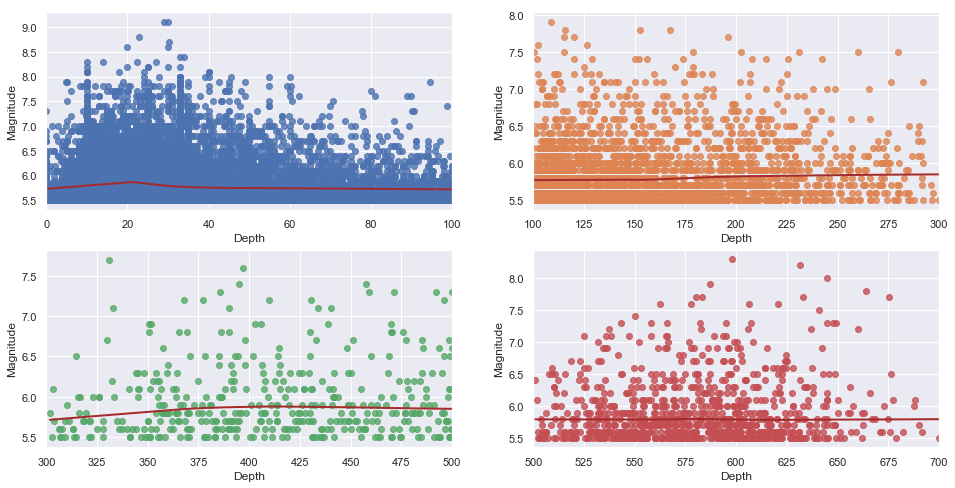

In [0]:
## Visualize depth, magnitude
# Scatter plot with splines using seaborn "lowess" or "robust" parameters
# LOWESS regression (locally weighted least square)

## plot by group of binned depths
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].set_xlim(0,100)
ax[0,1].set_xlim(100,300)
ax[1,0].set_xlim(300,500)
ax[1,1].set_xlim(500,700)
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='shallow'], 
                lowess=True, ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[0,0])
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='upper middle'], 
                lowess=True,ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[0,1])
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='lower middle'], 
                lowess=True, ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[1,0])
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='deep'], 
                lowess=True, ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[1,1])

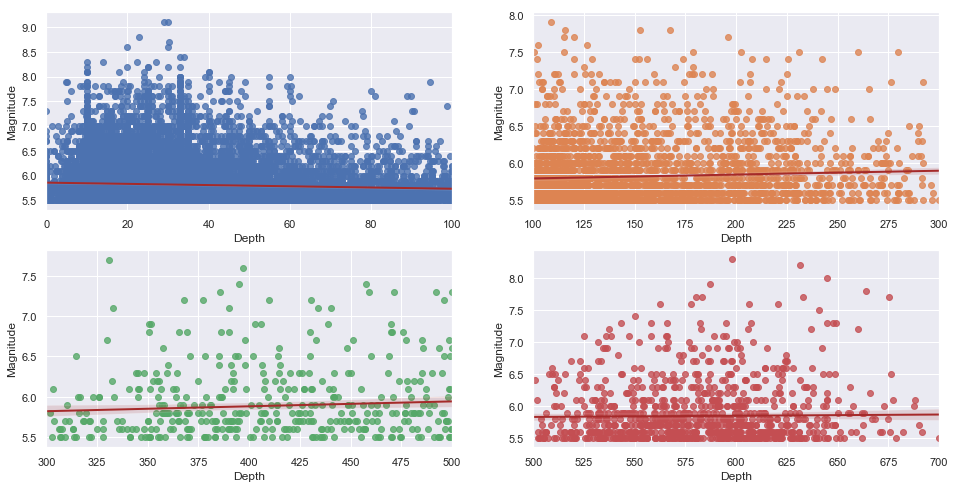

In [0]:
# robust regression with CI and 100 bootstrapping samples for CI estimation
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].set_xlim(0,100)
ax[0,1].set_xlim(100,300)
ax[1,0].set_xlim(300,500)
ax[1,1].set_xlim(500,700)
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='shallow'], 
                robust=True, ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[0,0])
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='upper middle'], 
                robust=True,ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[0,1])
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='lower middle'], 
                robust=True, ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[1,0])
seaborn.regplot(x='Depth', y='Magnitude', data=df[df['bin_dep']=='deep'], 
                robust=True, ci=95, n_boot=100, line_kws={"color":'brown', "linewidth":2}, ax=ax[1,1])

In [0]:
# binning groups of magnitudes and depths
def bin_magnitude(x):
    if x < 6.0:
        y = '5.5 - 5.9'
    elif x < 7.0:
        y = '6.0 - 6.9'
    elif x < 8.0:
        y = '7.0 - 7.9'
    else:
        y = '8.0 or above'
    return y

def bin_depth(x):
    if x <= 100:
        y = 'shallow'
    elif x <= 300:
        y = 'upper middle'
    elif x <= 500:
        y = 'lower middle'
    else:
        y = 'deep'
    return y
    
df['bin_mag'] = [bin_magnitude(x) for x in df['Magnitude']]
df['bin_dep'] = [bin_depth(x) for x in df['Depth']]

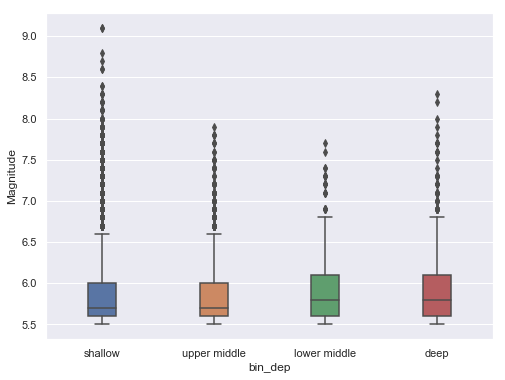

In [0]:
## dispersion of magnitude vs depths
seaborn.set(rc={'figure.figsize':(8.0, 6.0)})
seaborn.boxplot(x='bin_dep', y='Magnitude', data=df[['Magnitude', 'bin_dep']], 
                order=['shallow', 'upper middle', 'lower middle', 'deep'], width=0.25, whis=1.5)

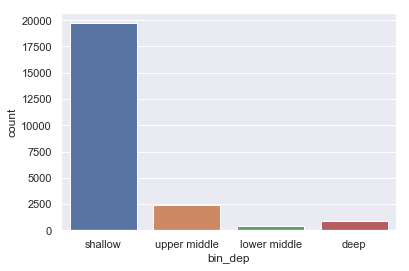

In [0]:
## number of earthquakes per binned depth
seaborn.set(rc={'figure.figsize':(6.0, 4.0)})
seaborn.countplot(x='bin_dep', data=df, order=['shallow', 'upper middle', 'lower middle', 'deep'])

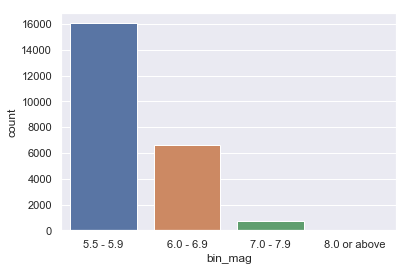

In [0]:
## number of earthquakes per binned magnitude
seaborn.countplot(x='bin_mag', data=df, order=['5.5 - 5.9', '6.0 - 6.9', '7.0 - 7.9', '8.0 or above'])

In [0]:
# cleaning improperly coded inputs
df['Date'][3378] = '1975-02-23'
df['Time'][3378] = '02:58:41'
df['Date'][7512] = '1985-04-28'
df['Time'][7512] = '02:53:41'
df['Date'][20650] = '2011-03-13'
df['Time'][20650] = '02:23:34'
# create a datetime column that allows numerical operations to apply for processing
df['period'] = df['Date'].map(str) + " " + df['Time'].map(str)
df['period'] = pd.to_datetime(df['period'], format='%Y-%m-%d %H:%M:%S')

In [10]:
## duplicate check; duplicates sourced from different semantic stations
print("Duplicated Timestamp found: " + str(df['period'][df['period'].duplicated()==True].count()))
## new dataset eliminating dulicates
df2 = df[df['period'].duplicated()==False]

Duplicated Timestamp found: 19


In [0]:
print(df2.shape)

(23393, 15)


In [0]:
df2.iloc[0:10,:]

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,year,month,day,Loc_Dense_Areas,Loc_partition,bin_mag,bin_dep,period
0,1965-01-02,13:44:18,19.246,145.616,Earthquake,131.6,6.0,1965,1,2,3,16,6.0 - 6.9,upper middle,1965-01-02 13:44:18
1,1965-01-04,11:29:49,1.863,127.352,Earthquake,80.0,5.8,1965,1,4,5,12,5.5 - 5.9,shallow,1965-01-04 11:29:49
2,1965-01-05,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,1965,1,5,4,26,6.0 - 6.9,shallow,1965-01-05 18:05:58
3,1965-01-08,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,1965,1,8,0,8,5.5 - 5.9,shallow,1965-01-08 18:49:43
4,1965-01-09,13:32:50,11.938,126.427,Earthquake,15.0,5.8,1965,1,9,5,12,5.5 - 5.9,shallow,1965-01-09 13:32:50
5,1965-01-10,13:36:32,-13.405,166.629,Earthquake,35.0,6.7,1965,1,10,6,14,6.0 - 6.9,shallow,1965-01-10 13:36:32
6,1965-01-12,13:32:25,27.357,87.867,Earthquake,20.0,5.9,1965,1,12,-1,7,5.5 - 5.9,shallow,1965-01-12 13:32:25
7,1965-01-15,23:17:42,-13.309,166.212,Earthquake,35.0,6.0,1965,1,15,6,14,6.0 - 6.9,shallow,1965-01-15 23:17:42
8,1965-01-16,11:32:37,-56.452,-27.043,Earthquake,95.0,6.0,1965,1,16,0,8,6.0 - 6.9,shallow,1965-01-16 11:32:37
9,1965-01-17,10:43:17,-24.563,178.487,Earthquake,565.0,5.8,1965,1,17,4,26,5.5 - 5.9,deep,1965-01-17 10:43:17


#### Hidden Markov Model (HMM):

Hidden Markov Model has been widely used in analyzing sequential data, relying on the Markov property of a sequence of observations, as affected by the stochastic Markov process of another sequence(s) of latent unobservable variable(s). Based on what we could observe (the sequence of occurrence across the 30 spatially-clustered segments), the model treated every transition of discrete probability state at time t to be conditionally dependent on the transitional probability distribution of the previous state at time t - 1 only, as explained by the Markov memoryless property. 

Upon training the HMM with the time series data or given sequence of observations for the computations of parameters, the most likely state for the next timestep was determined by the Viterbi algorithm to maximize the probability among the paths to reach the next state, and the outcome of the next observation could be predicted by a state-to-outcome emission probability distribution, which could be gaussian or multinomial in common cases.

The following demonstrated a HMM with multinomial-distributed emission (clusters are discrete) trained using the sequence of earthquakes in these 30 K-means clusters from time 1 to time t - 10, and the HMM predicted the most likely segmented area that the next 5.5 or above magnitude earthquake would take place.

<img src="https://www.researchgate.net/profile/Jan_Bulla/publication/24115579/figure/fig1/AS:669552555864074@1536645177575/Basic-structure-of-a-Hidden-Markov-Model.png" width="500" />

Last 10 timesteps were reserved for testing purpose. The predictions of the fitted Hidden Markov Model was based on the last state returned and the related transition probability matrix computed from the convergence of probability of the state transitions in the obeserved sequence. Conceptually, due to this conditional independence of the historical paths, when the model predicted the state and emitted label for the next time step t + 1, the transition probability matrix and emission probability matrix needed to be updated. 

Due to stochasticity of HMM, we could sample the next state from all candidates in the Markov chain as weighted by the probability density, but not simply take the maximum probability, as HMM is a probabilistic generative model. The observed sequence possessed a large variance such that the diagonals of the converged transition matrix dominated the transitions. Trying to generate predictions repeatedly for a number of runs, we can get a probability distribution of the states to be appeared in the next 10 timesteps, and conclude a most probable prediction from the samples.

The model correctly predicted the label on time t + 1, i.e. the regional segment the next large earthquake would take place. For timesteps t + 2 to t + 10, we did a weighted sampling for 5 runs. Compared to the actual results, the model had given true alerts for the occurrence of earthquakes at the region segments labelled 0 and 4, yet also false alarms for region labels 14 and 26. Occurrences at labels 2, 6 and 21 were not detected by the model.

In [0]:
# 2) Predicting the next possible earthquake regions, depths and magnitudes
# Hidden Markov Model (HMM)
from hmmlearn import hmm
np.random.seed(42)
from sklearn.utils import check_random_state
from numpy.random import choice

## Leave-p-out for testing
train_hmm = np.array(df2['Loc_partition'].head(len(df2) - 10))
test_hmm = np.array(df2['Loc_partition'].tail(len(df2) - len(train_hmm)))

## fit a multinomial HMM
model_hmm = hmm.MultinomialHMM(n_components=30, algorithm="viterbi", n_iter=300)
model_hmm.fit(train_hmm.reshape(-1, 1))

In [0]:
## generate predictions
def generate_samples_for_future(runs):

  next_state_pred = []
  next_label_pred = []

  for j in range(runs):

    next_state_pred_per_run = []
    next_label_pred_per_run = []

    for i in range(10):
      train_hmm = np.array(df2['Loc_partition'].head(len(df2) - 10))
      ## get the most likely hidden states for the training data
        ### current state = last predicted hidden state in training data
        ### at time t+1, predict next state from current state at time t
        ### sample a state among the transition probabilities for the next transition
      if i==0:
        state_region_hmm = model_hmm.predict(train_hmm.reshape(-1, 1))
        prob_next_state = model_hmm.transmat_[state_region_hmm[-1],:]
        state_next = prob_next_state.argmax()
      else:
        state_region_hmm = np.append(state_region_hmm, sample_state_next)
        state_next = sample_state_next

      ## get the emission probability distribution matrix for labels
        ### return label for this state
      label_next = model_hmm.emissionprob_[state_next,:].argmax()
      next_state_pred_per_run.append(state_next)
      next_label_pred_per_run.append(label_next)

      ## update the sequence
      train_hmm = np.append(train_hmm, label_next)

      ## sample a state among the probabilities for the next transition
      sample_state_next = choice(np.arange(0,30), 1, p=seq_region_infer.transmat_[state_region_hmm[-1],:])

    next_state_pred.append(next_state_pred_per_run)
    next_label_pred.append(next_label_pred_per_run)

  return next_state_pred, next_label_pred

next_state_pred, next_label_pred = generate_samples_for_future(runs=5)

In [0]:
# predict the regional cluster for the occurrence of earthquake at time t + 1
print("Predicted Label at time t + 1: ")
for a in range(5):
  print("Run " + str(a+1) + ": " + str(next_label_pred[a][0]))
print("Actual Label at time t + 1: " + str(test_hmm[0]))

Predicted Label at time t + 1: 
Run 1: 22
Run 2: 22
Run 3: 22
Run 4: 22
Run 5: 22
Actual Label at time t + 1: 22


In [0]:
# predict the regional cluster for the occurrence of earthquake at time t
print("Predicted Label at time t + 2 to t + 10: ")
for a in range(5):
  print("Run " + str(a+1) + ": " + str(next_label_pred[a][1:]))
print("Actual Label at time t + 2 to t + 10: " + str(test_hmm[1:].tolist()))

Predicted Label at time t + 2 to t + 10: 
Run 1: [22, 22, 22, 4, 25, 12, 12, 7, 26]
Run 2: [22, 22, 22, 22, 22, 22, 22, 0, 0]
Run 3: [13, 4, 14, 14, 14, 14, 16, 19, 12]
Run 4: [14, 14, 22, 22, 22, 13, 26, 12, 0]
Run 5: [26, 4, 4, 29, 29, 17, 26, 26, 14]
Actual Label at time t + 2 to t + 10: [2, 2, 6, 21, 21, 21, 0, 4, 0]


#### Conditional Random Field (CRF):

Conditional Random Field is another type of graphical model taking context and sequence of observed labels into account in the algorithm. Typically marked by the distinctive applications in the field of Natural Entity Recognition (NER) to generate linguistical and entity tagging of words in sentences; and image semantics context generation. Different from HMM which conditioned on the latest state, CRF assumes a globally conditional dependence between features of an observed and an output label sequence, and the two sequences are jointly distributed. Markov property of sequential dependency on previous observations, similar to HMM, is manifested in linear-chain CRF, and the inference is likewise made with Viterbi algorithm or maximum a posteriori approximations.

While HMM is generative to find the most likely sequence and hidden states, CRF is discriminative that the conditional probability inferred for the prediction of labels follows the form of a softmax function. CRF learns from the pre-defined features, which can be extracted from the sequence, and models the sequential dependence and relationships more characterized like a classifier. 

<img src="https://i.stack.imgur.com/khcnl.png" />
<br><b>Reference from: </b>Sutton, Charles, and Andrew McCallum. <i>"An introduction to conditional random fields."</i> Foundations and Trends® in Machine Learning 4.4. (2012). p.267-373.


Py-crfsuite (or sklearn-crfsuite) is a package executed in Python environment for the fast CRF-suite application written in C++: <br> https://sklearn-crfsuite.readthedocs.io/en/latest/index.html. 

The CRF was fitted on features created from the depths and magnitudes in the past 200 lags, and the occurrence partitions of earthquake zones from t - 210 to t - 10, and used to predict the net 10 partition zones large-scale earthquakes would happen. Among the 10 testing timesteps, earthquakes actually occurred in only 6 zones. The predictions given by the fitte CRF model were also distributed in 6 zones, and among these 6 predicted zones of potential risk, 3 zones turned out to have earthquakes eventually happened. This suggested a comparable performance to the HMM fitted above, both getting 3 matching alerts out of 6 zones (segments 22, 4, 0 in common). One thing CRF might be better in some sense as it is discriminative, it did not require repeated stochastic sampling and generation of probabilistic predictions as in the inference procedure of HMM.

In [0]:
df2['Loc_partition'] = df2['Loc_partition'].astype('category')
df2['Loc_Dense_Areas'] = df2['Loc_Dense_Areas'].astype('category')

In [0]:
## create features of 200 time lagged events of the 3 features
shift_region_col, shift_depth_col, shift_magnitude_col = [], [], []
for lag in range(200):
  if lag < 1:
    shift_region = df2['Loc_partition'].shift(lag + 11)
    shift_depth = df2['Depth'].shift(lag + 11)
    shift_magnitude = df2['Magnitude'].shift(lag + 11)
  else:
    shift_region = pd.concat([shift_region, df2['Loc_partition'].shift(lag + 11)], axis=1)
    shift_depth = pd.concat([shift_depth, df2['Depth'].shift(lag + 11)], axis=1)
    shift_magnitude = pd.concat([shift_magnitude, df2['Magnitude'].shift(lag + 11)], axis=1)
  shift_region_col.append('Loc_partition_lag_' + str(lag + 11))
  shift_depth_col.append('Depth_lag_' + str(lag + 11))
  shift_magnitude_col.append('Magnitude_lag_' + str(lag + 11))

shift_region.columns, shift_depth.columns, shift_magnitude.columns = \
shift_region_col, shift_depth_col, shift_magnitude_col

In [0]:
## compile into dataframe and do train and test split
X_train = pd.concat([shift_region[210:-10], shift_depth[210:-10], shift_magnitude[210:-10]], axis=1)
y_train = pd.DataFrame(df2['Loc_partition'][210:-10])
X_test = pd.concat([shift_region[-10:], shift_depth[-10:], shift_magnitude[-10:]], axis=1)
y_test = pd.DataFrame(df2['Loc_partition'][-10:])

In [0]:
## convert into list of dictionaries of features and list of labels
X_train_dict = [[dict([i, str(x)] for i, x in d.items())] for d in X_train.to_dict('records')]
y_train_label = [[dict([i, str(x)] for i, x in d.items())['Loc_partition']] for d in y_train.to_dict('records')]
X_test_dict = [[dict([i, str(x)] for i, x in d.items())] for d in X_test.to_dict('records')]
y_test_label = [[dict([i, str(x)] for i, x in d.items())['Loc_partition']] for d in y_test.to_dict('records')]

In [23]:
import sklearn_crfsuite
crf = sklearn_crfsuite.CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=300, all_possible_transitions=True)
crf.fit(X_train_dict, y_train_label)

CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.1, c2=0.1, calibration_candidates=None,
    calibration_eta=None, calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=300,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)

In [0]:
## prediction by fitted CRF
y_pred = crf.predict(X_test_dict)

In [37]:
print("Predicted Label at time t + 1 to t + 10: ")
print(y_pred)
print("Actual Label at time t + 1 to t + 10: ")
print(y_test_label)

Predicted Label at time t + 1 to t + 10: 
[['22'], ['14'], ['22'], ['4'], ['12'], ['12'], ['14'], ['4'], ['0'], ['26']]
Actual Label at time t + 1 to t + 10: 
[['22'], ['2'], ['2'], ['6'], ['21'], ['21'], ['21'], ['0'], ['4'], ['0']]


#### Bayesian Network:


In [0]:
from pomegranate import *
### engineer features for the Bayes Net
### test the performance on 7 spatial clusters instead of 32 spatial clusters
### for depths and magnitudes, substitute continuous variables with the binned categorical variables, 
###   avoiding creating complexed node structures for training Bayes Net 

shift_area_col, shift_depth_bin_col, shift_magnitude_bin_col = [], [], []
for lag in range(200):
  if lag < 1:
    shift_area = df2['Loc_Dense_Areas'].shift(lag + 11)
    shift_depth_bin = df2['bin_dep'].shift(lag + 11)
    shift_magnitude_bin = df2['bin_mag'].shift(lag + 11)
  else:
    shift_area = pd.concat([shift_area, df2['Loc_Dense_Areas'].shift(lag + 11)], axis=1)
    shift_depth_bin = pd.concat([shift_depth_bin, df2['bin_dep'].shift(lag + 11)], axis=1)
    shift_magnitude_bin = pd.concat([shift_magnitude_bin, df2['bin_mag'].shift(lag + 11)], axis=1)
  shift_area_col.append('Area_lag_' + str(lag + 11))
  shift_depth_bin_col.append('Depth_lag_' + str(lag + 11))
  shift_magnitude_bin_col.append('Magnitude_lag_' + str(lag + 11))

shift_area.columns, shift_depth_bin.columns, shift_magnitude_bin.columns = \
shift_area_col, shift_depth_bin_col, shift_magnitude_bin_col

X_train = pd.concat([shift_area[210:-10], shift_depth_bin[210:-10], shift_magnitude_bin[210:-10]], axis=1)
y_train = pd.DataFrame(df2['Loc_Dense_Areas'][210:-10])
X_test = pd.concat([shift_area[-10:], shift_depth_bin[-10:], shift_magnitude_bin[-10:]], axis=1)
y_test = pd.DataFrame(df2['Loc_Dense_Areas'][-10:])

In [0]:
'''from documentation:
   "chow-liu" will return the optimal tree-like structure for the Bayesian network, which is a very fast approximation but not always the best network;
   "greedy" that greedily attempts to find the best structure, and frequently can identify the optimal structure
   "exact"/"exact-dp" uses Dynamic Programming / A* to find the optimal Bayesian network'''

BN = BayesianNetwork.from_samples(pd.concat([X_train, y_train], axis=1), algorithm='chow-liu')

In [0]:
BN.fit(pd.concat([X_train, y_train], axis=1))

In [0]:
## prepare a data matrix with the label blanked out
test_sample = pd.concat([X_test.reset_index(drop=True), pd.DataFrame([None]*10)],axis=1)
test_sample.columns = [x for x in test_sample.columns[:-1]] + ['Loc_Dense_Areas']

In [0]:
## gather predicted inference from the Bayes Net
pred_proba = []
for i in range(10):
  pred_proba.append(BN.predict_proba(test_sample.values.tolist()[i])[-1].items())

In [0]:
## get the predicted sequence
decode_label = []
for i in range(len(pred_proba)):
  for c in range(len(pred_proba[i])):
    if c==0:
      prob = pred_proba[i][c][1]
      class_ = pred_proba[i][c][0]
    else:
      if prob < pred_proba[i][c][1]:
        prob = pred_proba[i][c][1]
        class_ = pred_proba[i][c][0]
  decode_label.append(class_)

In [131]:
print(decode_label)
print([y_test.values[z][0] for z in range(len(y_test))])

[-1, 6, 3, 6, -1, 6, -1, 6, 6, -1]
[6, 1, 1, -1, 2, 2, 2, 3, 5, 3]


In [126]:
print(decode_label)
print([y_test.values[z][0] for z in range(len(y_test))])

[-1, 6, 3, 6, -1, 6, -1, 6, 6, -1]
[6, 1, 1, -1, 2, 2, 2, 3, 5, 3]


#### Long-Short Term Memory network (LSTM)

For predicting the numerical features: Depth and Magnitude, a Long Short Term Memory recurrent neural network would worth attention and efforts, as rare large earthquake events often have long cycles for recurrence, LSTM could retain the feature weightings given to each timestep and update them upon iterating through the time series. Before training, some data cleaning had to be done and the most important part was to create a regularly-spaced time interval to reduce the complexity for modelling. The time series was transformed to a monthly basis. Three aggregated features were given as:
    1) count of earthquakes
    2) average depth of all earthquakes
    3) largest magnitude recorded for all earthquakes

In [0]:
# 3) Aggregate Standardize the time interval and extract the largest magnitude earthquake within each interval
##   Create count of earthquake; time of occurrence, and time lapse between previous intervals

# focus on the major earthquake zones, remove unlabelled cluster
df2 = df[df['Loc_Dense_Areas'] != -1]

# cleaning improperly coded inputs
df2['Date'][3378] = '1975-02-23'
df2['Time'][3378] = '02:58:41'
df2['Date'][7512] = '1985-04-27'
df2['Time'][7512] = '02:53:41'
df2['Date'][20650] = '2011-03-13'
df2['Time'][20650] = '02:23:34'
# create a datetime column that allows numerical operations to apply for processing
df2['period'] = df2['Date'].map(str) + " " + df2['Time'].map(str)
df2['occur'] = pd.to_datetime(df2['period'], format='%Y-%m-%d %H:%M:%S')

# aggregations
df3 = df2.groupby(['year', 'month', 'Loc_Dense_Areas']).agg({'Depth':['mean'],
                 'Magnitude':['max'], 'occur':['count','min','max']})
df3 = df3.reset_index(level=['year', 'month', 'Loc_Dense_Areas'])
df3.columns = ['year', 'month', 'Loc_Dense_Areas', 'Average_depth', 'Max_magnitude',
               'count', 'first_occur', 'last_occur']

For demonstration purpose, I selected the South-American earthquake cluster for training model. To complete the time series, I needed to fill the missing months when no earthquake occurred (count = 0). Meanwhile, I further added the time delta between the first occurrence in current month and the last occurrence in previous month, as well as the average number of waiting days for the next event to occur: *(Last occurrence in the month - First occurrence in the month) / (Count - 1)*, to see if the lapse of time between consecutive earthquakes could affect the outcome of future earthquakes.

In [0]:
# select cluster 1
df_1 = df3[df3['Loc_Dense_Areas']==1] # South-American Plate boundary
# reset the index from 0
df_1 = df_1.reset_index(drop=True)
# remove column
df_1.pop('Loc_Dense_Areas')

# filling zero count in the time series
def complete_count_zero(data):
    x = 0
    y = 1
    z = 1965
    comp = []
    for c in range(0, (2016-1965+1)*12):
        if data.iloc[x,1] != y:
            comp.append([z, y, 0, 0, 0, np.NaN, np.NaN])
        else:
            x = x + 1
        y = y + 1
        if y > 12:
            y = 1
            z = z + 1
    d_zero = pd.DataFrame(comp)
    d_zero.columns = data.columns
    return pd.concat([data, d_zero])

df_1 = complete_count_zero(df_1)
df_1 = df_1.sort_values(by=['year', 'month'])
df_1 = df_1.reset_index(drop=True)

## Make time-based features
from datetime import timedelta
# compute time delta to first occurrence in current interval to last occurrence in previous interval
def compute_lapse_between_intervals(data):
    for j in range(0, len(data)):
        if pd.isnull(data.iloc[j,6]) == False:
            s = data.iloc[j,6]
            z = j
            break
    lapse = []
    for i in range(0, len(data)):
        if pd.isnull(data.iloc[i,6]) == False:
            if i == z:
                gap = timedelta(days=0)
            else:
                gap = data.iloc[i,5] - s
                s = data.iloc[i,6]
        else:
            gap = timedelta(days=0)
        lapse.append(gap)
    return lapse

df_1['lapse'] = compute_lapse_between_intervals(df_1)

# compute the average intervals between earthquake occurrence
def compute_average_intervals_between_occurrence(data):
    result = []
    for i in range(0, len(data)):
        if data['count'][i] != 0 and data['count'][i] != 1:
            gap = (data['last_occur'][i] - data['first_occur'][i]) / (data['count'][i] - 1)
        else:
            gap = timedelta(days=0)
        result.append(gap)
    return result

df_1['average_time_between_occurrence'] = compute_average_intervals_between_occurrence(df_1)

After cleaning and pre-processing, the time plot could be created, and the stationarity of the time series could be tested by the Augmented Dickey Fuller Test provided by the functionality in the **statsmodel** library. It tests whether the time series could search a unit root, and if it could as the null hypothesis stated, it would be non-stationary. Rejection of the null guarantees stationarity.

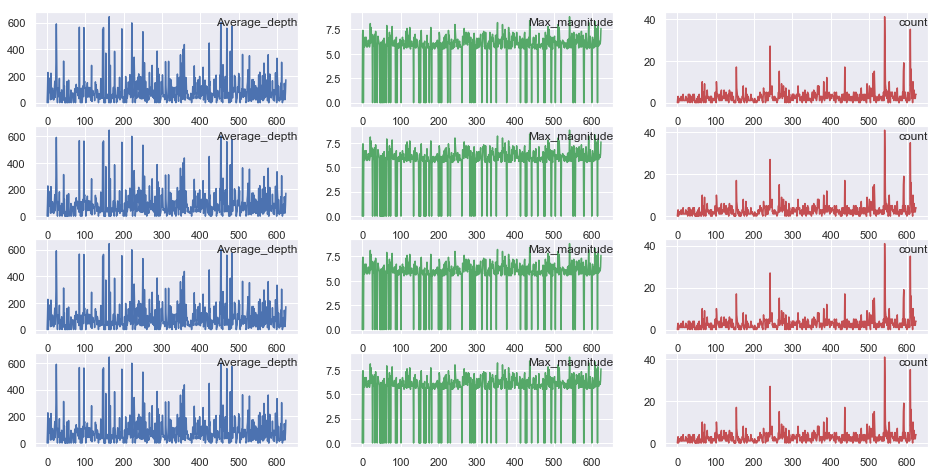

In [0]:
# check time plots & stationarity
def time_plot(data):
    f, ax = plt.subplots(nrows=4, ncols=3)
    for i in range(0,4):
        ax[i,0].plot(data.iloc[:,2], 'b')
        ax[i,1].plot(data.iloc[:,3], 'g')
        ax[i,2].plot(data.iloc[:,4], 'r')
        ax[i,0].set_title(data.columns[2], y=0.8, loc='right')
        ax[i,1].set_title(data.columns[3], y=0.8, loc='right')
        ax[i,2].set_title(data.columns[4], y=0.8, loc='right')

seaborn.set(rc={'figure.figsize':(16.0, 8.0)})
time_plot(df_1)

In [0]:
# stationary given p<0.05
from statsmodels.tsa.stattools import adfuller
def stationarity_test(x):
    adtest = adfuller(x)
    test_stat = adtest[0]
    p_val = adtest[1]
    print('ADFuller Test Statistic: %f' % test_stat)
    print('ADFuller P-value: %f' % p_val)

stationarity_test(df_1['count'])
stationarity_test(df_1['Average_depth'])
stationarity_test(df_1['Max_magnitude'])

ADFuller Test Statistic: -18.583083
ADFuller P-value: 0.000000
ADFuller Test Statistic: -24.241643
ADFuller P-value: 0.000000
ADFuller Test Statistic: -24.729070
ADFuller P-value: 0.000000


For fitting LSTM, time lagged columns could be produced with the *shift()* function in **pandas**. To determine how many lags to take, the auto-correlation function plots (ACF) could be a reference. I took 3 lags for 'count' as judged from the ACF, 1 lag for average depth and maximum magnitude for facilitating the model learning respectively. Values of these 3 features in future time points were the targets for prediction, and thus this should be a multi-variate time series problem. 7 features were used, including the 5 lagged features and the 2 time delta features. 

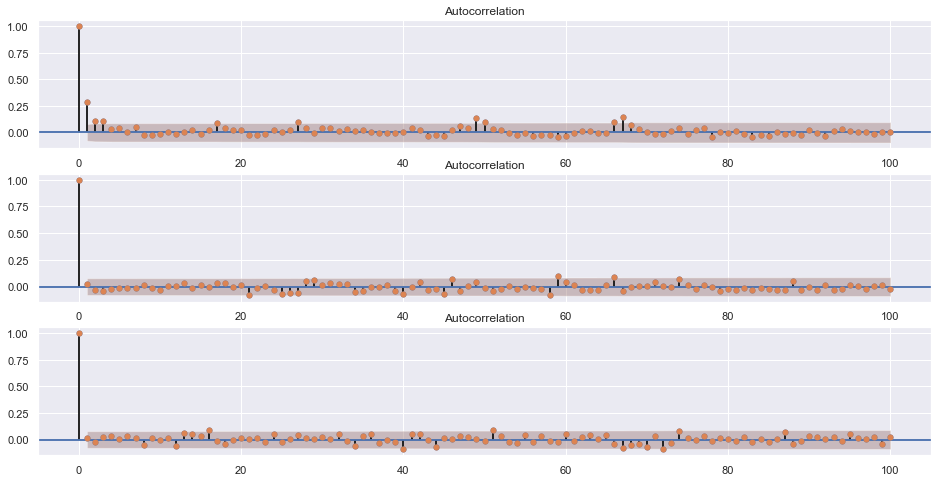

In [0]:
# Train a LSTM RNN for predicting the counts of earthquakes in particular zones
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.layers import Masking
from keras import regularizers
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error

# Create lags and determine the number of shifts via autocorrelation plots
from statsmodels.graphics.tsaplots import plot_acf

seaborn.set(rc={'figure.figsize':(16.0, 8.0)})

plot_acf(df_1['count'], lags=100, ax=ax[0])         # lag = 1-3, 49, 67
plot_acf(df_1['Average_depth'], lags=100, ax=ax[1]) # lag = 0
plot_acf(df_1['Max_magnitude'], lags=100, ax=ax[2]) # lag = 0

In [0]:
# Focus on the first 3 features to make shifts
for i in range(1,4):
    df_1['count_lag%d' % i] = df_1['count'].shift(i)

df_1['Average_depth_lag%d' % 1] = df_1['Average_depth'].shift(1)
df_1['Max_magnitude_lag%d' % 1] = df_1['Max_magnitude'].shift(1)

# Scaling the features
scaler = StandardScaler()
# Convert time-delta to float, and as a fraction comparable to 1 day difference
dfs_1 = df_1.iloc[:, np.r_[0:5, 7:14]]
dfs_1['lapse'] = dfs_1['lapse'].apply(lambda x: 
    pd.to_timedelta(x).total_seconds() / timedelta(days=1).total_seconds())
dfs_1['average_time_between_occurrence'] = dfs_1['average_time_between_occurrence'].apply(lambda x:
    pd.to_timedelta(x).total_seconds() / timedelta(days=1).total_seconds())
dfs_1.iloc[:,2:12] = scaler.fit_transform(dfs_1.iloc[:,2:12])
# Mask NaN on lagged features to -1 to ensure network running
dfs_1.fillna(-99, inplace=True)

In [0]:
dfs_1.tail(10)

,year,month,Average_depth,Max_magnitude,count,lapse,average_time_between_occurrence,count_lag1,count_lag2,count_lag3,Average_depth_lag1,Max_magnitude_lag1
614,2016,3,-0.891701,-2.931052,-0.837102,-1.302720,-0.831259,0.023452,-0.262343,0.881676,-0.668325,0.355460
615,2016,4,-0.762987,1.135889,2.029811,2.149279,-0.712054,-0.835998,0.023933,-0.262568,-0.890189,-2.929551
616,2016,5,-0.673166,0.666627,-0.263719,0.291496,-0.766135,2.028836,-0.834894,0.023493,-0.761521,1.137605
617,2016,6,-0.032612,0.093084,0.309663,-0.195980,0.328485,-0.263031,2.027862,-0.834691,-0.671732,0.668318
618,2016,7,-0.677510,0.353785,0.883046,-0.464295,-0.162993,0.309936,-0.262343,2.025921,-0.031408,0.094745
619,2016,8,0.487521,0.301645,-0.263719,-0.764342,1.033119,0.882902,0.310209,-0.262568,-0.676075,0.355460
620,2016,9,0.048579,0.249505,0.022972,0.266625,-0.381586,-0.263031,0.882760,0.309554,0.488538,0.303317
621,2016,10,-0.674973,0.197364,-0.263719,1.458577,-0.272176,0.023452,-0.262343,0.881676,0.049754,0.251174
622,2016,11,-0.114629,0.405925,0.309663,-1.008319,0.124344,-0.263031,0.023933,-0.262568,-0.673539,0.199031
623,2016,12,0.743081,1.031609,0.309663,-0.604330,0.565107,0.309936,-0.262343,0.023493,-0.113395,0.407603


Standardization was used for scaling the variables, because when using Min-Max normalization to values between 0 and 1, it would lead to small variation in the predicted outcome (small difference taking 4 to 5 decimal places). -99 was the value indicating missing for lagged columns, and this would be passed to the Masking layer prior to the LSTM layer, which told the learning model to ignore the row if the entire observation appeared to be the masking value.

The trained model would predict the outcomes for the latest 18 months in the dataset. One trick for the inputting data in LSTM is that the data need to be reshaped into 3 dimensions, representing number of observations, number of time steps in one batch and number of features accordingly. L1 and L2 regularization could be added to deal with overfitting. A single time step was treated as 1 batch. Wiith 2 hidden layer, eventually 3 units were passed to activation in the output layer for the 3 outcomes.

Particularly, *stateful=True* needs to be specified to disable the reset of state parameters at each run, which would be determining because the reset of state parameters would casue the model to discard the long-term dependency over time steps.

In [0]:
# Splitting dataset
# predict the latest 18 months for testing
Train_df1 = dfs_1.head(int(np.ceil(len(dfs_1) * 0.97)))
Test_df1 = dfs_1.tail(len(dfs_1) - len(Train_df1))
train_X, train_y = Train_df1.iloc[:,5:12].values, Train_df1.iloc[:,2:5].values
test_X, test_y = Test_df1.iloc[:,5:12].values, Test_df1.iloc[:,2:5].values
# 3 dimensions for (observations, timestep, features)
train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
train_y = train_y.reshape(train_y.shape[0], 1, train_y.shape[1])
test_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])
test_y = test_y.reshape(test_y.shape[0], 1, test_y.shape[1])

# define model:
# stateful LSTM disables resetting the hidden state per iteration, 
# retaining the time ordering characteristics of the data during the training process
# Add regularizers are added to avoid overfitting in hidden layers
model = Sequential()
model.add(Masking(mask_value=-99, batch_input_shape=(1, 1, train_X.shape[2])))
model.add(LSTM(120, activation='tanh', recurrent_activation='hard_sigmoid',
               batch_input_shape=(1, 1, train_X.shape[2]),
               stateful=True, return_sequences=True))
model.add(Dense(60, activation='linear', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(24, activation='linear', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Dense(3))
model.add(Activation('linear'))
model.compile(loss='mean_absolute_error', optimizer='adam')

# fit on training data
fit1 = model.fit(train_X, train_y, epochs=100, batch_size=1, shuffle=False)

Epoch 1/100
606/606 [==============================] - 4s 7ms/step - loss: 0.9739
Epoch 2/100
606/606 [==============================] - 2s 3ms/step - loss: 0.5763
Epoch 3/100
606/606 [==============================] - 2s 4ms/step - loss: 0.5513
Epoch 4/100
606/606 [==============================] - 2s 3ms/step - loss: 0.5535
Epoch 5/100
606/606 [==============================] - 2s 3ms/step - loss: 0.5430
Epoch 6/100
606/606 [==============================] - 2s 3ms/step - loss: 0.5417
Epoch 7/100
606/606 [==============================] - 2s 3ms/step - loss: 0.5401
Epoch 8/100
606/606 [==============================] - 2s 4ms/step - loss: 0.5291
Epoch 9/100
606/606 [==============================] - 2s 4ms/step - loss: 0.5274
Epoch 10/100
606/606 [==============================] - 2s 4ms/step - loss: 0.5210
Epoch 11/100
606/606 [==============================] - 2s 3ms/step - loss: 0.5240
Epoch 12/100
606/606 [==============================] - 2s 3ms/step - loss: 0.5162
Epoch 13/100


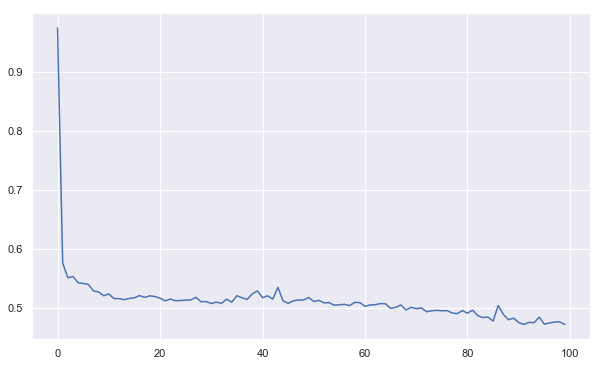

In [0]:
# plot the declining curve in the loss function
seaborn.set(rc={'figure.figsize':(10.0, 6.0)})
plt.plot(fit1.history['loss'], label='train')

In [0]:
# prediction on testing data
pred_1 = model.predict(test_X, batch_size=1)
pred_1 = pred_1.reshape(test_y.shape[0], test_y.shape[2])
# invert to original scale
inv_1a = np.concatenate((train_y.reshape(train_y.shape[0], train_y.shape[2]),
                      train_X.reshape(train_X.shape[0], train_X.shape[2])), axis=1)
inv_1b = np.concatenate((pred_1, test_X.reshape(test_X.shape[0], test_X.shape[2])), axis=1)
inv_1 = np.concatenate((inv_1a, inv_1b), axis=0)
inv_1 = scaler.inverse_transform(inv_1)

# Actual vs Predict
x1 = df_1.iloc[-18:,2:5]
y1 = pd.DataFrame(inv_1[-18:,0:3])
y1.columns = x1.columns
x1['Class'] = "Actual"
y1['Class'] = "Predicted"
x1['time'] = np.array(range(1,19))
y1['time'] = pd.Series(range(1,19))
xy1 = pd.concat([x1, y1])

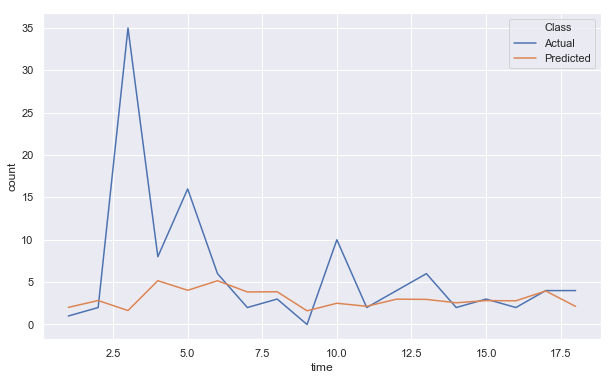

In [0]:
seaborn.lineplot(x='time', y=xy1.iloc[:,2], hue='Class', data=xy1) #count

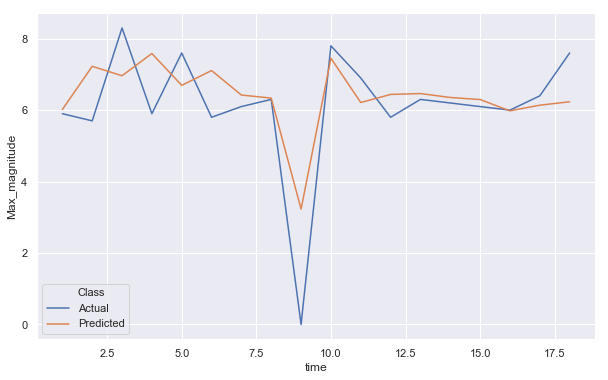

In [0]:
seaborn.lineplot(x='time', y=xy1.iloc[:,1], hue='Class', data=xy1) #max_magnitude

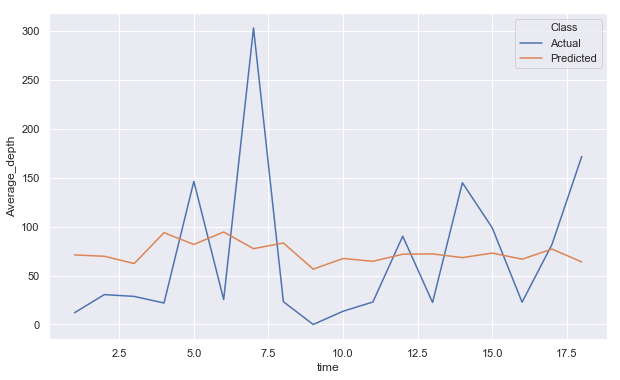

In [0]:
seaborn.lineplot(x='time', y=xy1.iloc[:,0], hue='Class', data=xy1) #average_depth

The learning rate of the model seemed to be high that the loss did not decrease much after the first 10 - 20 epochs. Undergoing 100 epochs, the model only predicted well on the count of earthquakes for few occrrence periods. It could not deal with extreme values, like on the 3rd month, there were 35 occurrences, and 16 occurrences on the 5th month. Extremely frequent occurrences within one month might suggest that there was a major earthquake followed by a series of aftershocks. The model failed to learn the effect of aftershocks. However, it generally had better performance on the maximum magnitude. The abrupt changes on the 9th and 10th month were sucessfully simulated by the model's predicted value. For average depth, the model probably could not distinguish its difference from other features, and hence had a poor prediction. We might consider re-engineering this feature for further training.